**Lie/ True Classifier Using RNN**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import dlib

dataset_path = os.listdir('/content/TruthOrLie/train')

label_types = os.listdir('/content/TruthOrLie/train')
print (label_types)

['lie', 'truth']


**Preparing Training Data**

In [ ]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/TruthOrLie/train' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/TruthOrLie/train' + '/' +item) + '/' + room))

# Build a dataframe
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())

   tag                                         video_name
0  lie  /content/TruthOrLie/train/lie/trial_lie_011_00...
1  lie  /content/TruthOrLie/train/lie/trial_lie_017_00...
2  lie  /content/TruthOrLie/train/lie/trial_lie_033_00...
3  lie  /content/TruthOrLie/train/lie/trial_lie_053_00...
4  lie  /content/TruthOrLie/train/lie/trial_lie_009_00...
       tag                                         video_name
816  truth  /content/TruthOrLie/train/truth/trial_truth_02...
817  truth  /content/TruthOrLie/train/truth/trial_truth_03...
818  truth  /content/TruthOrLie/train/truth/trial_truth_01...
819  truth  /content/TruthOrLie/train/truth/trial_truth_05...
820  truth  /content/TruthOrLie/train/truth/trial_truth_00...


In [ ]:
df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

**Preparing Test Data**

In [ ]:
dataset_path = os.listdir('/content/TruthOrLie/test')
print(dataset_path)

room_types = os.listdir('/content/TruthOrLie/test')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/TruthOrLie/test' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/TruthOrLie/test' + '/' +item) + '/' + room))

# Build a dataframe
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['lie', 'truth']
Types of activities found:  2
     tag                                         video_name
0    lie  /content/TruthOrLie/test/lie/trial_lie_001_000...
1    lie  /content/TruthOrLie/test/lie/trial_lie_001_002...
2    lie  /content/TruthOrLie/test/lie/trial_lie_001_003...
3    lie  /content/TruthOrLie/test/lie/trial_lie_001_001...
4  truth  /content/TruthOrLie/test/truth/trial_truth_001...
     tag                                         video_name
3    lie  /content/TruthOrLie/test/lie/trial_lie_001_001...
4  truth  /content/TruthOrLie/test/truth/trial_truth_001...
5  truth  /content/TruthOrLie/test/truth/trial_truth_001...
6  truth  /content/TruthOrLie/test/truth/trial_truth_001...
7  truth  /content/TruthOrLie/test/truth/trial_truth_001...


In [ ]:
#!pip install git+https://github.com/tensorflow/docs

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import keras

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

**Data preparation**

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


train_df.sample(10)

Total videos for training: 821
Total videos for testing: 8


,Unnamed: 0,video_name,tag
151,151,/content/TruthOrLie/train/lie/trial_lie_052_00...,lie
369,369,/content/TruthOrLie/train/lie/trial_lie_052_01...,lie
464,464,/content/TruthOrLie/train/truth/trial_truth_05...,truth
356,356,/content/TruthOrLie/train/lie/trial_lie_005_00...,lie
736,736,/content/TruthOrLie/train/truth/trial_truth_00...,truth
120,120,/content/TruthOrLie/train/lie/trial_lie_028_00...,lie
24,24,/content/TruthOrLie/train/lie/trial_lie_049_00...,lie
538,538,/content/TruthOrLie/train/truth/trial_truth_01...,truth
533,533,/content/TruthOrLie/train/truth/trial_truth_04...,truth
477,477,/content/TruthOrLie/train/truth/trial_truth_06...,truth


**Feed the videos to a network:**

In [ ]:
IMG_SIZE = 224


# def crop_center_square(frame):
#     y, x = frame.shape[0:2]
#     min_dim = min(y, x)
#     start_x = (x // 2) - (min_dim // 2)
#     start_y = (y // 2) - (min_dim // 2)
#     return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


# def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
#     cap = cv2.VideoCapture(path)
#     frames = []
#     try:
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             frame = crop_center_square(frame)
#             frame = cv2.resize(frame, resize)
#             frame = frame[:, :, [2, 1, 0]]
#             frames.append(frame)

#             if len(frames) == max_frames:
#                 break
#     finally:
#         cap.release()
#     return np.array(frames)

def extract_face(frame, resize=(IMG_SIZE, IMG_SIZE)):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray)

    if len(faces) == 0:
        # If no face is detected, return None
        return None

    # Assuming we want to extract the first detected face
    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()

    # Crop the face from the frame
    face_image = frame[y:y+h, x:x+w]
    face_image = cv2.resize(face_image, resize)

    return face_image

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            face_frame = extract_face(frame, resize)
            if face_frame is not None:
                face_frame = face_frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
                frames.append(face_frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()

    return np.array(frames)

**Feature Extraction**

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

**Label Encoding:** StringLookup layer encode the class labels as integers.

In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels

['lie', 'truth']


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

# MAX_SEQ_LENGTH = 20, NUM_FEATURES = 2048. We have defined this above under hyper parameters

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 141ms/step
Frame features in train set: (821, 20, 2048)
Frame masks in train set: (821, 20)
train_labels in train set: (821, 1)
test_labels in train set: (8, 1)


**The sequence model:** Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

EPOCHS = 100
# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 0.6054 - accuracy: 0.7224
Epoch 1: val_loss improved from inf to 1.04588, saving model to ./tmp/video_classifier
18/18 [==============================] - 17s 345ms/step - loss: 0.6016 - accuracy: 0.7230 - val_loss: 1.0459 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.7526
Epoch 2: val_loss did not improve from 1.04588
18/18 [==============================] - 1s 66ms/step - loss: 0.5257 - accuracy: 0.7526 - val_loss: 1.0645 - val_accuracy: 0.0000e+00
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 0.5094 - accuracy: 0.7537
Epoch 3: val_loss did not improve from 1.04588
18/18 [==============================] - 1s 48ms/step - loss: 0.5101 - accuracy: 0.7509 - val_loss: 1.0519 - val_accuracy: 0.0000e+00
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 0.4732 - accuracy: 0.7610
Epoch 4: val_loss improved from 1.0

In [ ]:
model_json = sequence_model.to_json()
with open("sequence_model.json",'w') as json_file:
    json_file.write(model_json)
sequence_model.save("sequence_model.h5")

**Inference**

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)

Test video path: /content/TruthOrLie/test/lie/trial_lie_001_000.mp4
1/1 [==============================] - 0s 37ms/step
  lie: 53.14%
  truth: 46.86%


**Đánh giá mô hình**

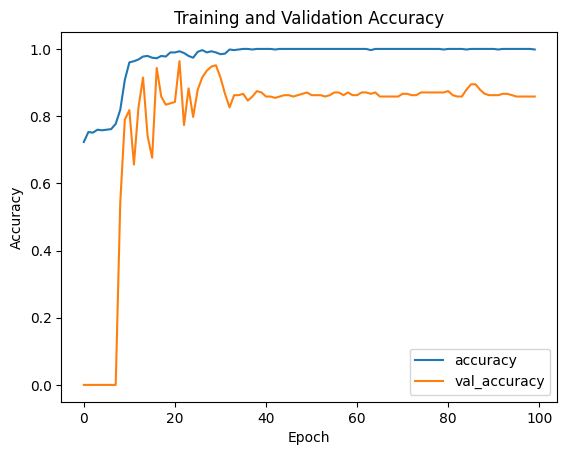

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ accuracy và val_accuracy theo epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 56ms/step


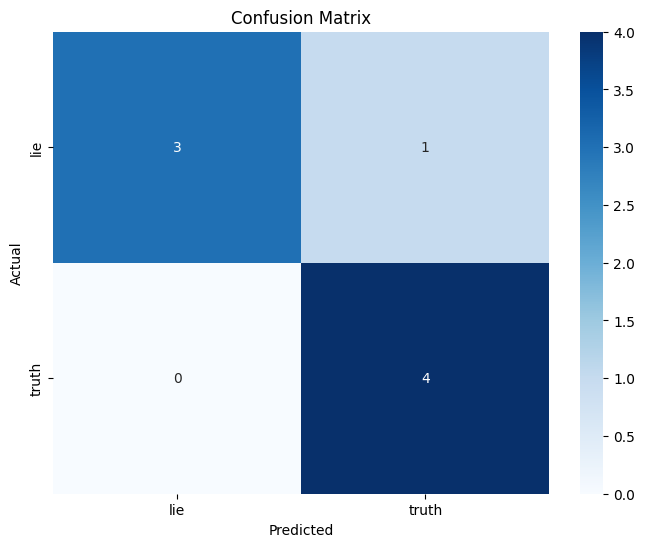

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_vocab=['lie','truth']

# Dự đoán trên tập dữ liệu test
predictions = sequence_model.predict([test_data[0], test_data[1]])
predicted_labels = np.argmax(predictions, axis=1)

# Tính confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_vocab, yticklabels=class_vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Dự đoán trên tập dữ liệu test
predictions = sequence_model.predict([test_data[0], test_data[1]])
predicted_labels = np.argmax(predictions, axis=1)

# In classification report
print(classification_report(test_labels, predicted_labels, target_names=class_vocab))


1/1 [==============================] - 0s 47ms/step
              precision    recall  f1-score   support

         lie       1.00      0.75      0.86         4
       truth       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

